In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from spreadsheet_data_handling import tweak_for_sentiment

### Load data

In [2]:
df_tweak_sent = pd.read_csv('../pxtextmining/datasets/v6framework_230831.csv').pipe(tweak_for_sentiment)
df_tweak_sent.sample(10).style.set_caption(f'shape: {df_tweak_sent.shape}')

,Comment ID,Trust,Respondent ID,Date,question_type,answer_clean,answer_char_len,answer_word_len,Comment sentiment,sentiment_desc
5925,NEAS 111 1839 - Q3,NEAS,NEAS 111 1839,07/04/2022,nonspecific,The call was great they recommended a ambulance the was the paramedic who was arrogant,86,15,3,neutral
11,NEAS PTS 561 - Q1,NEAS,NEAS PTS 561,30/09/2021,nonspecific,Not your problem but something must be done to relieve the handover times at hospital.,86,15,4,negative
3629,NEAS PTS 1476 - Q2,NEAS,NEAS PTS 1476,31/05/2022,could_improve,Drive very good.,16,3,1,very positive
6431,NEAS S&C 4342 - Q1,NEAS,NEAS S&C 4342,26/04/2022,nonspecific,"Because the call handler was very professional and the paramedics arrived in good time, dealt with the patient quickly and calmly, kept us informed of what they were doing and got the patient to hospital quickly",211,36,2,positive
7788,NEAS 111 1972 - Q2,NEAS,NEAS 111 1972,03/05/2022,could_improve,To support the system.,22,4,3,neutral
6501,NEAS S&C 4937 - Q1,NEAS,NEAS S&C 4937,07/06/2022,nonspecific,The ambiance was there in 40 minutes the two paramedics were excellent,70,12,2,positive
4,NEAS PTS 540 - Q1,NEAS,NEAS PTS 540,30/09/2021,nonspecific,Cue waiting time by an hour.,28,6,3,neutral
906,NEAS S&C 5845 - Q2,NEAS,NEAS S&C 5845,09/08/2022,could_improve,Kept me informed accurately and truthfully,42,6,2,positive
6063,NEAS 111 2353 - Q1,NEAS,NEAS 111 2353,12/07/2022,nonspecific,If we had been given an appointment with dental hospital that would have been great,83,15,4,negative
2742,NHFT 1357 - Q2,NHFT,NHFT 1357,14/03/2022,what_good,The help I received from my clinical team.,42,8,2,positive


### Stratified split

In [3]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(
    df_tweak_sent, random_state=0, shuffle=True, stratify=df_tweak_sent['Comment sentiment'], test_size=0.5
)

df_trn

,Comment ID,Trust,Respondent ID,Date,question_type,answer_clean,answer_char_len,answer_word_len,Comment sentiment,sentiment_desc
3909,NEAS S&C 3151 - Q2,NEAS,NEAS S&C 3151,1/18/2022,could_improve,Can't think of any,18,4,2,positive
3432,NEAS PTS 882 - Q2,NEAS,NEAS PTS 882,31/01/2022,could_improve,All patient transport drivers have been very h...,66,10,1,very positive
628,NEAS S&C 3482 - Q2,NEAS,NEAS S&C 3482,18/02/2022,could_improve,One crew of three people disappeared back to t...,217,41,4,negative
1739,NHFT 1865 - Q1,NHFT,NHFT 1865,01/02/2022,could_improve,Not sure.,9,2,3,neutral
2562,NHFT 832 - Q1,NHFT,NHFT 832,07/10/2021,could_improve,Nothing.,8,1,1,very positive
...,...,...,...,...,...,...,...,...,...,...
3772,NEAS PTS 1905 - Q2,NEAS,NEAS PTS 1905,30/09/2022,could_improve,"The staff are all friendly, caring, and consid...",134,24,1,very positive
6929,NHFT 728 - Q1,NHFT,NHFT 728,30/09/2021,could_improve,No staff to go off the ward with them.,38,9,4,negative
7822,NEAS S&C 2563 - Q1,NEAS,NEAS S&C 2563,01/11/2021,nonspecific,Very busy but kept us updated on approximate r...,58,10,3,neutral
6392,NEAS S&C 4010 - Q2,NEAS,NEAS S&C 4010,08/04/2022,could_improve,Nothing,7,1,1,very positive


### Cap answer lengths to 300

In [4]:
df_trn = df_trn.assign(**{
    'answer_clean': lambda df_: df_['answer_clean'].apply(lambda v_: v_[:300]),
    'answer_char_len': lambda df_: df_['answer_clean'].map(len)
})
df_trn.sample(5)

,Comment ID,Trust,Respondent ID,Date,question_type,answer_clean,answer_char_len,answer_word_len,Comment sentiment,sentiment_desc
4085,NEAS S&C 4656 - Q1,NEAS,NEAS S&C 4656,5/24/2022,nonspecific,Ambulance service was really good came quick a...,178,36,2,positive
2530,NHFT 651 - Q2,NHFT,NHFT 651,23/09/2021,what_good,"A lot of information given, great service. Exc...",62,9,2,positive
967,NEAS S&C 6364 - Q1,NEAS,NEAS S&C 6364,21/09/2022,nonspecific,Very quick and vey professional tge lady was a...,52,9,1,very positive
2218,NEAS 111 2176 - Q2,NEAS,NEAS 111 2176,31/05/2022,could_improve,It took your staff 15 hours to call be back.,44,10,4,negative
2433,NHFT 239 - Q1,NHFT,NHFT 239,13/07/2021,could_improve,Nothing.,8,1,1,very positive


### Get `vader` scores

In [5]:
analyzer = SentimentIntensityAnalyzer()

vader_scores = pd.DataFrame(
    df_trn['answer_clean'].apply(analyzer.polarity_scores).to_list(),
    index=df_trn.index
)
vader_scores.columns = ['vader_' + col for col in vader_scores.columns]

vader_scores

,vader_neg,vader_neu,vader_pos,vader_compound
3909,0.000,1.000,0.000,0.0000
3432,0.000,0.546,0.454,0.7688
628,0.161,0.773,0.066,-0.5435
1739,0.662,0.338,0.000,-0.2411
2562,0.000,1.000,0.000,0.0000
...,...,...,...,...
3772,0.000,0.623,0.377,0.9022
6929,0.216,0.784,0.000,-0.2960
7822,0.000,1.000,0.000,0.0000
6392,0.000,1.000,0.000,0.0000


Join vader scores with data

In [6]:
df_trn = df_trn.join(vader_scores)
df_trn

,Comment ID,Trust,Respondent ID,Date,question_type,answer_clean,answer_char_len,answer_word_len,Comment sentiment,sentiment_desc,vader_neg,vader_neu,vader_pos,vader_compound
3909,NEAS S&C 3151 - Q2,NEAS,NEAS S&C 3151,1/18/2022,could_improve,Can't think of any,18,4,2,positive,0.000,1.000,0.000,0.0000
3432,NEAS PTS 882 - Q2,NEAS,NEAS PTS 882,31/01/2022,could_improve,All patient transport drivers have been very h...,66,10,1,very positive,0.000,0.546,0.454,0.7688
628,NEAS S&C 3482 - Q2,NEAS,NEAS S&C 3482,18/02/2022,could_improve,One crew of three people disappeared back to t...,217,41,4,negative,0.161,0.773,0.066,-0.5435
1739,NHFT 1865 - Q1,NHFT,NHFT 1865,01/02/2022,could_improve,Not sure.,9,2,3,neutral,0.662,0.338,0.000,-0.2411
2562,NHFT 832 - Q1,NHFT,NHFT 832,07/10/2021,could_improve,Nothing.,8,1,1,very positive,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,NEAS PTS 1905 - Q2,NEAS,NEAS PTS 1905,30/09/2022,could_improve,"The staff are all friendly, caring, and consid...",134,24,1,very positive,0.000,0.623,0.377,0.9022
6929,NHFT 728 - Q1,NHFT,NHFT 728,30/09/2021,could_improve,No staff to go off the ward with them.,38,9,4,negative,0.216,0.784,0.000,-0.2960
7822,NEAS S&C 2563 - Q1,NEAS,NEAS S&C 2563,01/11/2021,nonspecific,Very busy but kept us updated on approximate r...,58,10,3,neutral,0.000,1.000,0.000,0.0000
6392,NEAS S&C 4010 - Q2,NEAS,NEAS S&C 4010,08/04/2022,could_improve,Nothing,7,1,1,very positive,0.000,1.000,0.000,0.0000


### Get `TextBlob` scores

In [7]:
from textblob import TextBlob

#Returning mismatached length. Try sentences individually.
# tblob = TextBlob('\n'.join(df_trn['answer_clean'].str.replace('\n', ' ').to_list()))

tblob_list = df_trn['answer_clean'].map(TextBlob)

tb_scores = pd.Series(
    # [sentence.sentiment.polarity for sentence in tblob.sentences],
    [tb.sentences[0].sentiment.polarity for tb in tblob_list],
    index=df_trn.index,
    name='tb_score'
)

df_trn = df_trn.join(tb_scores)
df_trn

,Comment ID,Trust,Respondent ID,Date,question_type,answer_clean,answer_char_len,answer_word_len,Comment sentiment,sentiment_desc,vader_neg,vader_neu,vader_pos,vader_compound,tb_score
3909,NEAS S&C 3151 - Q2,NEAS,NEAS S&C 3151,1/18/2022,could_improve,Can't think of any,18,4,2,positive,0.000,1.000,0.000,0.0000,0.000000
3432,NEAS PTS 882 - Q2,NEAS,NEAS PTS 882,31/01/2022,could_improve,All patient transport drivers have been very h...,66,10,1,very positive,0.000,0.546,0.454,0.7688,0.466667
628,NEAS S&C 3482 - Q2,NEAS,NEAS S&C 3482,18/02/2022,could_improve,One crew of three people disappeared back to t...,217,41,4,negative,0.161,0.773,0.066,-0.5435,0.000000
1739,NHFT 1865 - Q1,NHFT,NHFT 1865,01/02/2022,could_improve,Not sure.,9,2,3,neutral,0.662,0.338,0.000,-0.2411,-0.250000
2562,NHFT 832 - Q1,NHFT,NHFT 832,07/10/2021,could_improve,Nothing.,8,1,1,very positive,0.000,1.000,0.000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,NEAS PTS 1905 - Q2,NEAS,NEAS PTS 1905,30/09/2022,could_improve,"The staff are all friendly, caring, and consid...",134,24,1,very positive,0.000,0.623,0.377,0.9022,0.487500
6929,NHFT 728 - Q1,NHFT,NHFT 728,30/09/2021,could_improve,No staff to go off the ward with them.,38,9,4,negative,0.216,0.784,0.000,-0.2960,0.000000
7822,NEAS S&C 2563 - Q1,NEAS,NEAS S&C 2563,01/11/2021,nonspecific,Very busy but kept us updated on approximate r...,58,10,3,neutral,0.000,1.000,0.000,0.0000,-0.135000
6392,NEAS S&C 4010 - Q2,NEAS,NEAS S&C 4010,08/04/2022,could_improve,Nothing,7,1,1,very positive,0.000,1.000,0.000,0.0000,0.000000


### How well do scores track labels?

Each score vs label

Of vader's metrics, `compound` tracks the label best.

TextBlob doesn't identify negative sentiment well. Vader a bit better there.

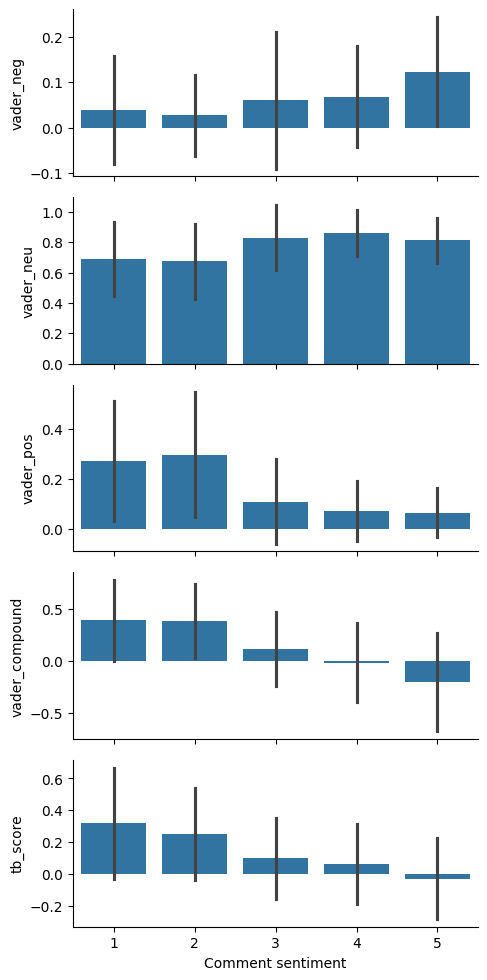

In [8]:
g = sns.PairGrid(
    df_trn,
    x_vars='Comment sentiment',
    y_vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'tb_score'],
    height=2, aspect=2.5
)
g.map(sns.barplot, errorbar='sd')
plt.show()

Compound score

Ok for positive, but 4 is scored neutral on average

vader better than textblob for tracking sentiment. Has a clearer trend.

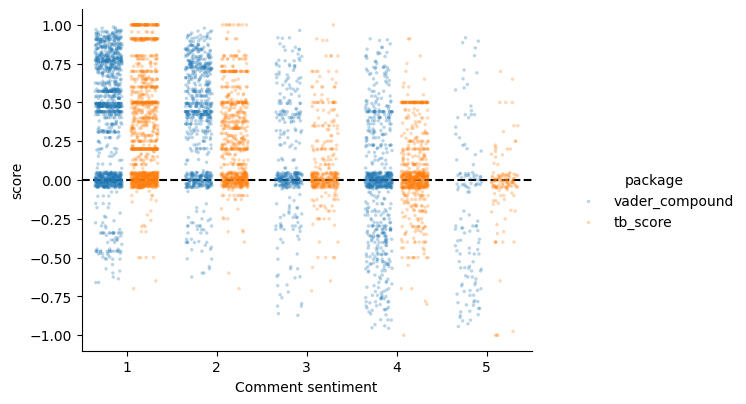

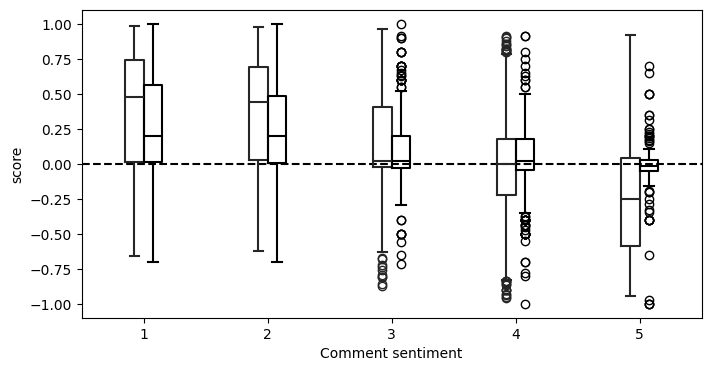

In [9]:
scores_melt = df_trn[['Comment sentiment', 'vader_compound',  'tb_score']].melt(
    id_vars='Comment sentiment',
    value_vars=['vader_compound', 'tb_score'],
    var_name='package',
    value_name='score',
    ignore_index=False
)

#Disperse values around 0 to aid qualitative assessment
scores_melt.loc[scores_melt.score.eq(0), 'score'] += np.random.uniform(-0.05, 0.05, size=scores_melt.score.eq(0).sum())

g = sns.catplot(
    scores_melt,
    x='Comment sentiment', y='score', hue='package',
    kind='strip', dodge=True,
    edgecolor='none', alpha=0.3, marker='.', jitter=0.3,
)
g.ax.figure.set_size_inches(8, 4)
g.ax.axhline(0, color='black', ls='--')
plt.show()

ax = sns.boxplot(
    scores_melt,
    x='Comment sentiment', y='score', hue='package', palette='dark:black',
    dodge=True, fill=False, linewidth=1.5, width=0.3, zorder=3, legend=False
)
ax.figure.set_size_inches(8, 4)
ax.axhline(0, color='black', ls='--')
plt.show()

Correlation measures

vader > textblob

`vader_compound` stronger relationship than `vader_neg`

In [10]:
from scipy.stats import spearmanr, pearsonr

print(
    'vader'.center(85, '~'), '\n',
    'spearmanr:', spearmanr(df_trn.vader_compound, df_trn['Comment sentiment']), '\n',
    'pearsonr:', pearsonr(df_trn.vader_compound, df_trn['Comment sentiment']), '\n',
    'R2:', pearsonr(df_trn.vader_compound, df_trn['Comment sentiment']).statistic**2,
    end='\n\n'
)

print(
    'textblob'.center(85, '~'), '\n',
    'spearmanr:', spearmanr(df_trn.tb_score, df_trn['Comment sentiment']), '\n',
    'pearsonr:', pearsonr(df_trn.tb_score, df_trn['Comment sentiment']), '\n',
    'R2:', pearsonr(df_trn.tb_score, df_trn['Comment sentiment']).statistic**2
)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~vader~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 spearmanr: SignificanceResult(statistic=-0.4045741279844142, pvalue=1.007761561255887e-121) 
 pearsonr: PearsonRResult(statistic=-0.4380738816284658, pvalue=1.0104931130990152e-144) 
 R2: 0.19190872576503104

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~textblob~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 spearmanr: SignificanceResult(statistic=-0.34743017442158847, pvalue=3.810284815005925e-88) 
 pearsonr: PearsonRResult(statistic=-0.35788828873095624, pvalue=8.587441346463187e-94) 
 R2: 0.1280840272107723
